## NPZ model and synthetic observations
### some preparation:
create synthetic (model-generated) data

In [1]:
using DifferentialEquations, StanSample, PyPlot, DataFrames, Statistics

In [2]:
# specify indices
i_n = 1
i_p = 2
i_z = 3

# specify parameter values
#        vmax, nuthalfsat, graz, mort_p, mort_z, irr0, irr1
theta = [0.15, 0.3,        0.02, 0.02,   0.03,   0.1,  0.2]

# vmax:       maximum growth rate in Michaelis Menten formulation
# nuthalfsat: nutrient half saturation in Michaelis Menten formulation
# graz:       zooplankton grazing rate
# mort_p:     phytoplankton mortality rate
# mort_z:     zooplankton mortality rate
# irr0:       light base level
# irr1:       light amplitude


# specify model 
function dxdt!(du,u,p,t)   
    light = p[6] + p[7]+p[7]*sin(π*((t-81.25)/182.5))
    growth = p[1]*u[i_n]/(p[2]+u[i_n]) * light * u[i_p]
    grazing = p[3]*u[i_p]*u[i_z]
    ploss = p[4]*u[i_p]
    zloss = p[5]*u[i_z]*u[i_z]
    du[1] = -growth+ploss+zloss # N
    du[2] = growth-grazing-ploss # P
    du[3] = grazing-zloss       # Z
end

dxdt! (generic function with 1 method)

In [3]:
# initial conditions
x0 = [0.6,0.15,0.23]

# initialize time vector
t = collect(0.0:1.0:2*365.0);

tspan = (0.0,2*365.0)

prob = ODEProblem(dxdt!, x0, tspan, theta)
sol = solve(prob,reltol=1e-6,saveat=1.0);

# reorganize sol.u into 2d array
x = reverse(rotl90(hcat(sol.u...)),dims=1);

In [4]:
iobs = sample(1:size(t,1)÷10,20,replace=false)*10;
iobs = sort(iobs)
tobs = t[iobs]
iobsvar = [i_p,i_z]
sigma = [0.03 0.03]
obs = max.(0.0, x[iobs,iobsvar] .+ randn(20,2) .* sigma);

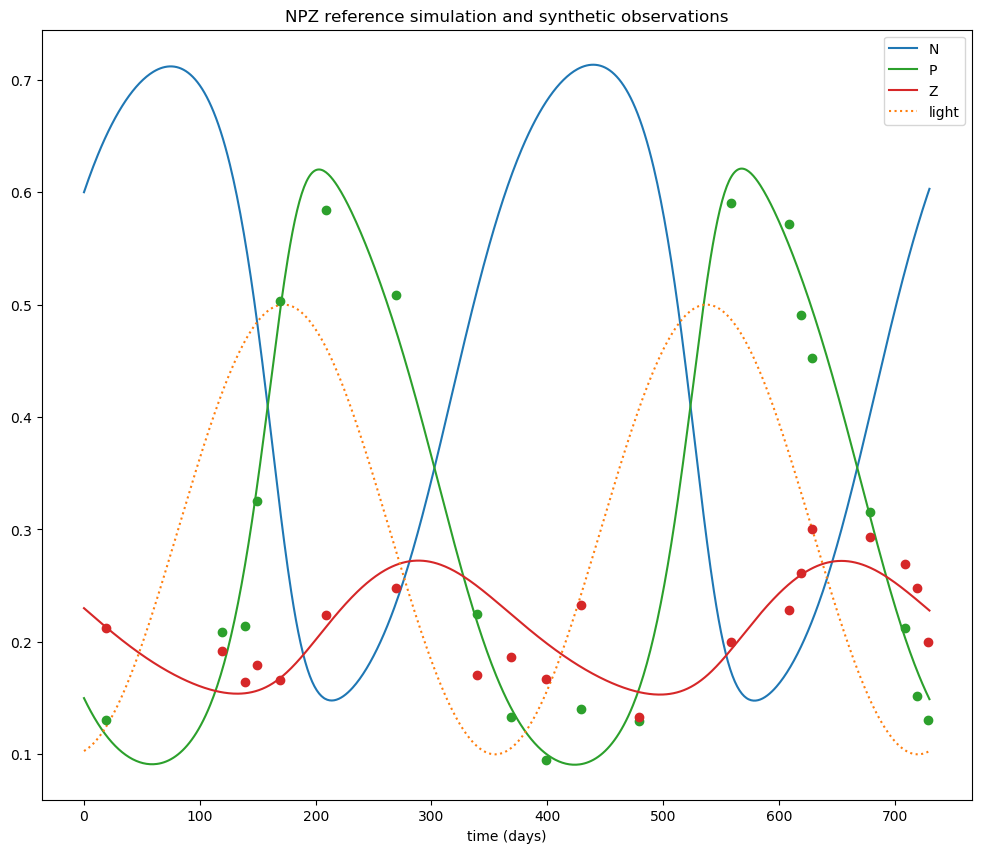

In [5]:
colors = ("#1f77b4","#2ca02c","#d62728") # colors for N, P, Z

light = theta[6] .+ theta[7] .+ theta[7] .* sin.(π.*((t.-81.25)./182.5))
cname = ["N", "P", "Z"]
fig,ax = plt.subplots(figsize=(12,10))
for i in 1:3
    ax.plot(t,x[:,i], color=colors[i], label=cname[i])
end
    ax.plot(t,light,linestyle=":",color="#ff7f0e",label="light")
for i in 1:2
    ax.plot(tobs, obs[:,i], color=colors[i+1], marker="o", ls="none")
end
ax.set(title="NPZ reference simulation and synthetic observations", xlabel="time (days)")
ax.legend();

### create and run Stan model

In [6]:
stan_code = """
functions {
   real[] npz(real t,       // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // fixed real data (empty)
              int[] x_i) {  // fixed integer data (empty)
   
    /*
    guide to theta:
    theta[1]:  vmax         maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat   nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz         zooplankton grazing rate
    theta[4]:  mort_p       phytoplankton mortality rate
    theta[5]:  mort_z       zooplankton mortality rate
    theta[6]:  irr0         light base level
    theta[7]:  irr1         light amplitude
    */

    real n = fmax(0.0, x[1]);
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real light = theta[6] + theta[7]+theta[7]*sin(pi()*((t-81.25)/182.5)); 
    real growth = theta[1]*n/(theta[2]+n) * light * p;
    real grazing = theta[3]*p*z;
    real ploss = theta[4]*p;
    real zloss = theta[5]*z*z;
    
    return {-growth+ploss+zloss,growth-grazing-ploss,grazing-zloss};
  }
}
data {
    int<lower=0> nobs;               // number of timesteps with observations
    real tobs[nobs];                 // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=1, P=2, Z=3)
    real<lower=0> obs[nobs,nobsvar]; // observed variable at measurement times
}
parameters {
    real<lower=0> vmax;
    real<lower=0> nuthalfsat;
    real<lower=0> graz;
    real<lower=0> mort_p;
    real<lower=0> mort_z;
    real<lower=0> irr0;
    real<lower=0> irr1;
    real<lower=0> x0[3];            // initial conditions
    real<lower=0> sigma[nobsvar];   // obs error
}
transformed parameters {
    //real theta[6];   // parameters
    //real x[nobs, 3];
    real theta[7] = {vmax,nuthalfsat,graz,mort_p,mort_z,irr0,irr1};
    real x[nobs, 3] = integrate_ode_rk45(npz, x0, 0, tobs, theta,
                                         rep_array(0.0, 0), rep_array(0, 0),
                                         1e-5, 1e-4, 1e4);
}
model {
    vmax       ~ normal(0.1, 0.1);
    nuthalfsat ~ uniform(0.0, 1.0);
    graz       ~ normal(0.01, 0.01);
    mort_p     ~ normal(0.01, 0.01);
    mort_z     ~ normal(0.01, 0.01);
    irr0       ~ normal(0.03, 0.03);
    irr1       ~ normal(0.1, 0.1);
    x0[1:3]    ~ normal(0.1, 0.1);
    for (iobs in 1:nobs){
        obs[iobs,] ~ normal(x[iobs,iobsvar], sigma);
    }
}
""";

In [7]:
sm = SampleModel("NPZ", stan_code)


/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_S6lk1B/NPZ.stan updated.


  name =                    "NPZ"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_S6lk1B"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [8]:
data = Dict("nobs" => size(tobs,1), "tobs" => tobs, "nobsvar" => size(iobsvar,1), "iobsvar" => iobsvar, "obs" => obs)

Dict{String,Any} with 5 entries:
  "nobs"    => 20
  "obs"     => [0.130675 0.211999; 0.208849 0.191714; … ; 0.151669 0.248275; 0.…
  "nobsvar" => 2
  "tobs"    => [19.0, 119.0, 139.0, 149.0, 169.0, 209.0, 269.0, 339.0, 369.0, 3…
  "iobsvar" => [2, 3]

In [17]:
(sample_file, log_file) = stan_sample(sm, data=data, n_chains = 4);

In [18]:
chns = read_samples(sm)

Object of type Chains, with data of type 1000×86×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = vmax, nuthalfsat, graz, mort_p, mort_z, irr0, irr1, x0.1, x0.2, x0.3, sigma.1, sigma.2, theta.1, theta.2, theta.3, theta.4, theta.5, theta.6, theta.7, x.1.1, x.2.1, x.3.1, x.4.1, x.5.1, x.6.1, x.7.1, x.8.1, x.9.1, x.10.1, x.11.1, x.12.1, x.13.1, x.14.1, x.15.1, x.16.1, x.17.1, x.18.1, x.19.1, x.20.1, x.1.2, x.2.2, x.3.2, x.4.2, x.5.2, x.6.2, x.7.2, x.8.2, x.9.2, x.10.2, x.11.2, x.12.2, x.13.2, x.14.2, x.15.2, x.16.2, x.17.2, x.18.2, x.19.2, x.20.2, x.1.3, x.2.3, x.3.3, x.4.3, x.5.3, x.6.3, x.7.3, x.8.3, x.9.3, x.10.3, x.11.3, x.12.3, x.13.3, x.14.3, x.15.3, x.16.3, x.17.3, x.18.3, x.19.3, x.20.3

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parame

In [19]:
ESS = ess(chns)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ vmax       │ 1957.14 │ 1.00206  │
│ 2   │ nuthalfsat │ 2288.09 │ 0.999767 │
│ 3   │ graz       │ 1203.08 │ 1.00739  │
│ 4   │ mort_p     │ 1743.54 │ 1.00634  │
│ 5   │ mort_z     │ 1200.9  │ 1.00661  │
│ 6   │ irr0       │ 2478.96 │ 1.0008   │
│ 7   │ irr1       │ 2036.94 │ 1.00185  │
│ 8   │ x0.1       │ 1831.01 │ 1.00145  │
│ 9   │ x0.2       │ 2572.04 │ 0.999617 │
│ 10  │ x0.3       │ 1973.69 │ 1.00286  │
│ 11  │ sigma.1    │ 2744.91 │ 1.00113  │
│ 12  │ sigma.2    │ 2098.52 │ 1.00182  │
│ 13  │ theta.1    │ 1957.14 │ 1.00206  │
│ 14  │ theta.2    │ 2288.09 │ 0.999767 │
│ 15  │ theta.3    │ 1203.08 │ 1.00739  │
│ 16  │ theta.4    │ 1743.54 │ 1.00634  │
│ 17  │ theta.5    │ 1200.9  │ 1.00661  │
│ 18  │ theta.6    │ 2478.96 │ 1.0008   │
│ 19  │ theta.7    │ 2036.94 │ 1.00185  │
│ 20  │ x.1.1      │ 1946.67 │ 1.00077  │
│ 21  │ x.2.1      │ 2202.68 

In [28]:
rawdata = DataFrame(chns, showall=true, sorted=true, append_chains=true);

In [34]:
# reshape the results
dat_summary = zeros(20,3,4)
for i in 1:20
    for j in 1:3
        dat_summary[i,j,1] = mean(rawdata[:,19+3*(i-1)+j])
        dat_summary[i,j,2] = quantile(rawdata[:,19+3*(i-1)+j],0.25)
        dat_summary[i,j,3] = quantile(rawdata[:,19+3*(i-1)+j],0.5)
        dat_summary[i,j,4] = quantile(rawdata[:,19+3*(i-1)+j],0.75)
    end
end

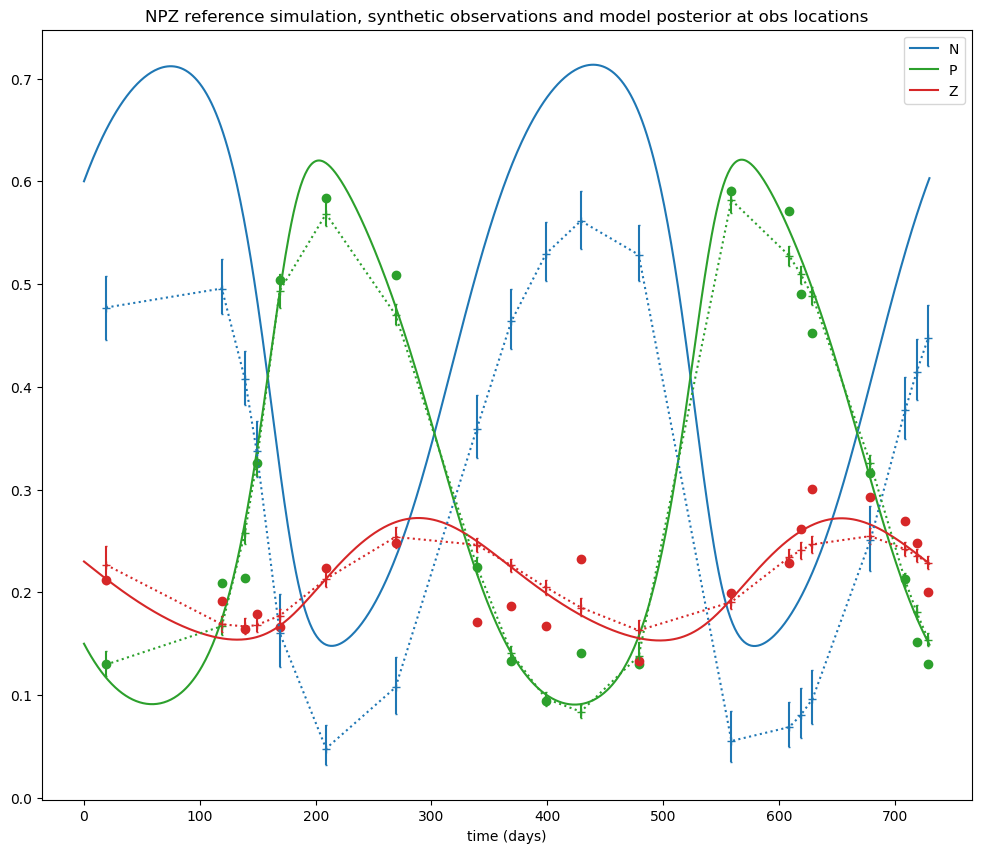

In [36]:
fig,ax = plt.subplots(figsize=(12,10))

for i in 1:3
    ax.plot(t,x[:,i], color=colors[i], label=cname[i])
    ax.errorbar(x=tobs, y=dat_summary[:,i,3], yerr=[dat_summary[:,i,3]-dat_summary[:,i,2],dat_summary[:,i,4]-dat_summary[:,i,3]], 
        ls=":", color=colors[i], marker="+", capsize=1.0)
end
for i in 1:2
    ax.plot(tobs, obs[:,i], color=colors[i+1], marker="o", ls="none")
end
ax.set(title="NPZ reference simulation, synthetic observations and model posterior at obs locations", xlabel="time (days)")
ax.legend();

In [39]:
# reshape rawdata
data_bp = zeros(4000,20,3)
for i in 1:20
    for j in 1:3
        data_bp[:,i,j] = rawdata[:,19+3*(i-1)+j]
    end
end

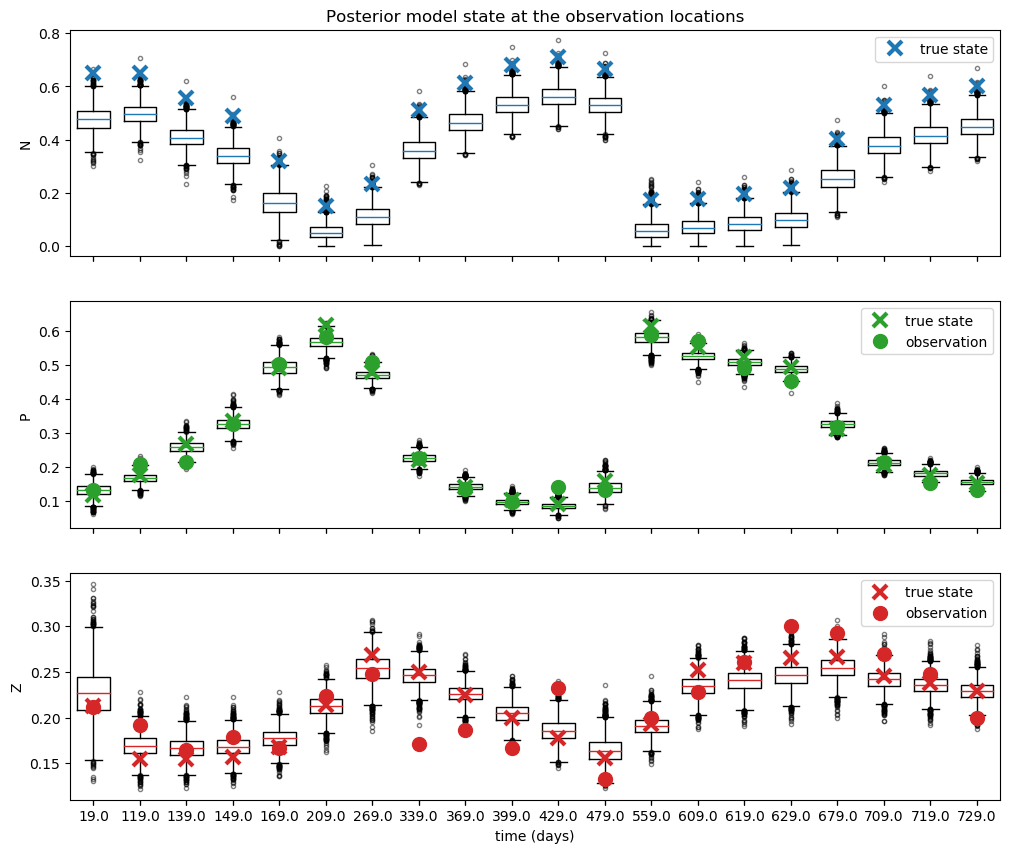

In [45]:
positions = collect(1:1:20)
fig,axs = plt.subplots(nrows=3, sharex=true, figsize=(12,10))
for i in 1:3
    axs[i].boxplot(data_bp[:,:,i], positions=positions, widths=0.7, medianprops=Dict("color"=>colors[i]),
    flierprops=Dict("marker"=>".", "alpha"=>0.5))
    axs[i].plot(positions, x[iobs,i], marker="x", markeredgewidth=3, markersize=10, ls="none", label="true state", color=colors[i])
    axs[i].set(ylabel=cname[i])
end
for i in 1:2
    axs[i+1].plot(positions, obs[:,i], marker="o", markersize=10, ls="none", label="observation", color=colors[i+1])
end
for ax in axs
    ax.legend()
end
axs[1].set(title="Posterior model state at the observation locations")
axs[3].set(xticklabels=tobs, xlabel="time (days)");